# PM2 — Conditioning and Sensitivity
Team: Camille Wardlaw, Manuel Valencia, Demircan Tas\\
Scope: Tasks C (Conditioning) and D (Sensitivity)

### Regression
- Runs model, Jacobian (analytical vs finite‑difference), and short stability checks.
- All tests passed: baseline verified; safe to proceed with PM2 analyses.

In [1]:
# Setup
import os, math, warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sp
from scipy.sparse.linalg import svds, spsolve
from numpy.linalg import cond as dense_cond

np.set_printoptions(suppress=True, linewidth=120)
np.random.seed(0)
plt.rcParams.update({'figure.figsize': (7.5,4.5), 'axes.grid': True})
os.makedirs('temp/pm2', exist_ok=True)
warnings.filterwarnings('ignore')


### Conditioning (A vs α)
- A = [[0 I]; [L −αI]]. Under steady (w=0) α cancels, so cond(A) vs α is flat.
- Larger grids increase cond(A); use as sanity only — L is the steady matrix of interest.

In [2]:
# Project imports
from getParam_Sonar import getParam_Sonar
from eval_f_Sonar import eval_f_Sonar
from eval_Jf_Sonar import eval_Jf_Sonar
from eval_Jf_FiniteDifference import eval_Jf_FiniteDifference
from eval_g_Sonar import eval_g_Sonar
from eval_u_Sonar import eval_u_Sonar
from simpleLeapFrog import LeapfrogSolver


### Conditioning (L)
- cond(L) increases with Nx; printed values are α‑independent by design.
- Digits of trust ≈ 16 − log10(cond(L)) (or −log10(cond(L)·δ) including parameter uncertainty δ).
- Pitfalls: very fine grids and weak damping are numerically stiff — consider preconditioning for larger cases.

In [3]:
# Helpers
def build_C(p):
    # Selector matrix C (H x 2N) that picks pressure at hydrophones.
    H = p['hydrophones']['n_phones']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    C = np.zeros((H, 2*N))
    z_pos = p['hydrophones']['z_pos']
    for h, x_idx in enumerate(p['hydrophones']['x_indices']):
        if x_idx < Nx:
            k = x_idx * Nz + z_pos
            C[h, k] = 1.0
    return C

def to_dense(A):
    return A.toarray() if sp.issparse(A) else np.array(A)

def extract_L(p):
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    Lblk = A[N:, :N]
    return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)

def solve_steady(p, u0=1.0):
    # Solve 0 = A x + B u0 for steady-state x (neglecting dynamics).
    A, B = p['A'], p['B']
    if sp.issparse(B):
        rhs = -(B * float(u0)).toarray().ravel()
    else:
        rhs = -(B * float(u0)).ravel()
    if sp.issparse(A):
        x = spsolve(A, rhs)
    else:
        x = np.linalg.solve(A, rhs)
    return x.reshape((-1,1))

def rebuild_params_like(p, **overrides):
    # Rebuild A (for alpha,c) and B (for source position) using existing structure.
    q = dict(p)
    is_sparse = sp.issparse(p['A'])
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    # Update alpha/c by reconstructing A blocks
    alpha_new = overrides.get('alpha', p['alpha'])
    c_new = overrides.get('c', p['c'])
    c_old = p['c']
    scale = (c_new / c_old)**2 if 'c' in overrides else 1.0
    if is_sparse:
        L_blk = A[N:, :N]
        I_N = sp.eye(N, format='csr')
        L_new = L_blk * scale
        A_new = sp.bmat([[sp.csr_matrix((N, N)), I_N],
                         [L_new, -alpha_new * I_N]], format='csr')
    else:
        L_blk = A[N:, :N]
        I_N = np.eye(N)
        L_new = L_blk * scale
        A_new = np.block([[np.zeros((N, N)), I_N],
                         [L_new, -alpha_new * I_N]])
    q['A'] = A_new
    q['alpha'] = alpha_new
    q['c'] = c_new
    # Update B if sonar position overrides are provided
    si = overrides.get('sonar_ix', p['sonar_ix'])
    sj = overrides.get('sonar_iz', p['sonar_iz'])
    if ('sonar_ix' in overrides) or ('sonar_iz' in overrides):
        def idx(i,j):
            return i * Nz + j
        if is_sparse:
            B = sp.lil_matrix((2*N,1), dtype=float)
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B.tocsr()
        else:
            B = np.zeros((2*N,1))
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B
        q['sonar_ix'] = si
        q['sonar_iz'] = sj
    return q


### Sensitivity dp selection (steady QoI)
- Absolute vs relative curves: pick dp in the plateau (between truncation at large dp and roundoff at tiny dp).
- Steady QoI: α ≈ 0 as expected; c is influential.
- Report dp near the middle of the plateau for each parameter.

## Quick Regression (sanity)

### Transient α (peak hydrophone amplitude)
- α affects dynamics: peak |y(t)| shows non‑zero sensitivity; steady‑state hides this.
- Use dp plateau for reporting |d y_peak / dα|.

COMPLETE SONAR MODEL TEST SUITE

PART A: MODEL FUNCTIONALITY TESTS

TEST 1: Matrix Dimensions
----------------------------------------
✓ PASSED: Matrix dimensions correct

TEST 2: Zero Input Response
----------------------------------------
✓ PASSED: Zero state remains stable

TEST 3: Source Excitation
----------------------------------------
✓ PASSED: Source generates signal: 9.51e-01 Pa

TEST 4: CFL Condition
----------------------------------------
✓ PASSED: Timestep 0.001241 respects CFL

TEST 5: Hydrophone Configuration
----------------------------------------
✓ PASSED: 5 hydrophones configured

TEST 6: Short-term Stability
----------------------------------------
started running a simple solver, please wait...
✓ PASSED: No immediate divergence

PART B: JACOBIAN TEST BENCH

TEST 7: Linear System Check
----------------------------------------
✓ PASSED: Jacobian equals A matrix (linear system)

TEST 8: Finite Difference Verification
----------------------------------------
  dx = 1.

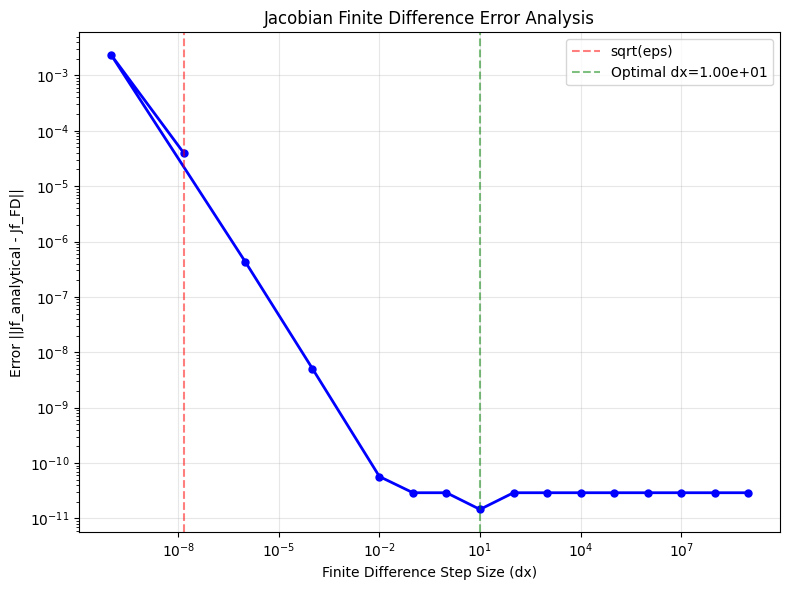


COMPLETE TEST SUMMARY
Total Tests Passed: 10
Total Tests Failed: 0
Overall Success Rate: 100.0%

✓ ALL TESTS PASSED!
PM2 regression summary — passed: 10, failed: 0


In [4]:
from test_Sonar import test_sonar_complete
passed, failed = test_sonar_complete()
print(f'PM2 regression summary — passed: {passed}, failed: {failed}')

### Source index sensitivity (per hydrophone)
- Largest magnitudes near the source direction (x or z).
- Sign shows direction: moving the source toward (+) or away (−) a hydrophone increases/decreases pressure.

## Task C — Conditioning

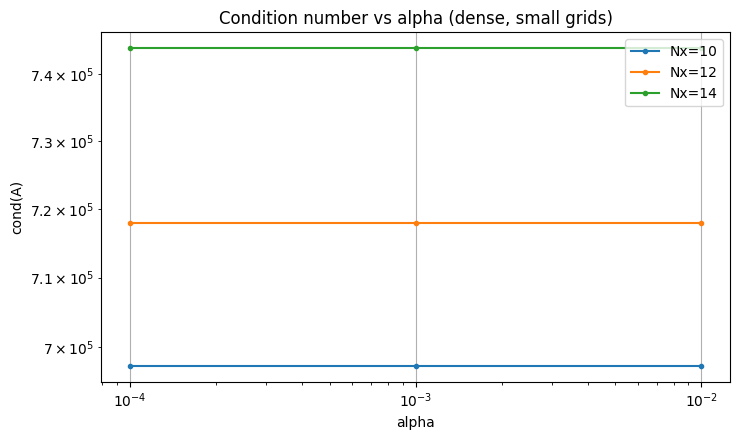

In [5]:
# Explore cond(A) vs alpha and grid size (dense for small grids)
def measure_cond(Nx_list=(10,12,14), Nz=10, Lx=100, Lz=50, alphas=(1e-4, 1e-3, 1e-2)):
    records = []
    for Nx in Nx_list:
        for alpha in alphas:
            p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
            p = rebuild_params_like(p, alpha=alpha)
            A = to_dense(p['A'])
            try:
                kappa = dense_cond(A)
            except Exception:
                kappa = np.nan
            records.append((Nx, alpha, kappa))
    return np.array(records, dtype=object)

rec = measure_cond()
for Nx in sorted(set(rec[:,0])):
    mask = rec[:,0]==Nx
    plt.loglog(rec[mask,1].astype(float), rec[mask,2].astype(float), '.-', label=f'Nx={int(Nx)}')
plt.xlabel('alpha')
plt.ylabel('cond(A)')
plt.title('Condition number vs alpha (dense, small grids)')
plt.legend(); plt.tight_layout(); plt.show()


## Task D — Sensitivity (Finite Differences)

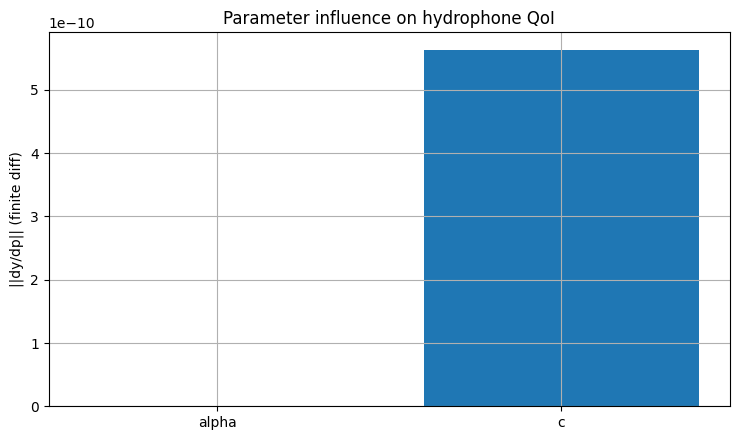

In [6]:
# Define QoI: hydrophone pressures y = C x (steady-state, constant u)
def compute_y(p, u0=1.0):
    x = solve_steady(p, u0=u0)
    C = build_C(p)
    return (C @ x).reshape(-1,1)

def finite_diff_sens(p, pname, dp, u0=1.0):
    # baseline
    y0 = compute_y(p, u0)
    # perturbed parameter
    pval = p[pname]
    p_pert = rebuild_params_like(p, **{pname: pval + dp})
    y1 = compute_y(p_pert, u0)
    return (y1 - y0) / dp

# Example run
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
# Choose dp per PM2 guidance
eps = np.finfo(float).eps
dp_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_c = math.sqrt(2*eps) * max(1.0, abs(p['c']))

S_alpha = finite_diff_sens(p, 'alpha', dp_alpha)
S_c     = finite_diff_sens(p, 'c', dp_c)

# Rank sensitivities by magnitude (sum across hydrophones)
mag = np.array([np.linalg.norm(S_alpha), np.linalg.norm(S_c)])
labels = ['alpha', 'c']
plt.bar(labels, mag)
plt.ylabel('||dy/dp|| (finite diff)')
plt.title('Parameter influence on hydrophone QoI')
plt.tight_layout(); plt.show()


## Task C — Conditioning of L (steady matrix)

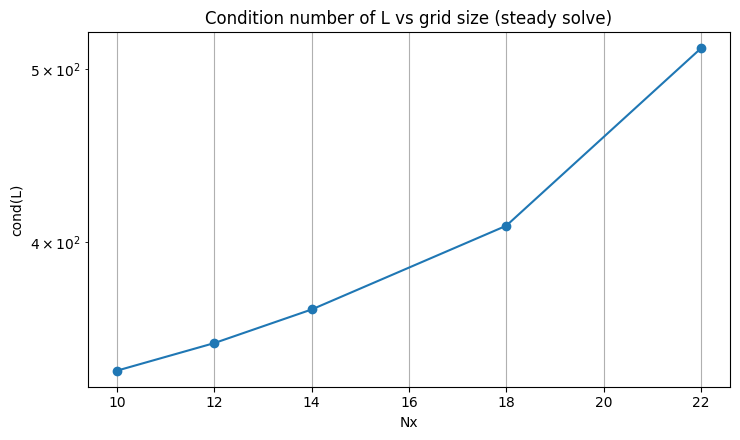

cond(L) @ alpha=1e-4: 366.64905597825197
cond(L) @ alpha=1e-2: 366.64905597825197


In [7]:
# cond(L) vs Nx (alpha-independent)
def measure_cond_L(Nx_list=(10,12,14,18,22), Nz=10, Lx=100, Lz=50):
    vals = []
    for Nx in Nx_list:
        p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
        L = extract_L(p)
        try:
            kappa = dense_cond(L)
        except Exception:
            kappa = np.nan
        vals.append((Nx, kappa))
    return np.array(vals, dtype=float)

vals = measure_cond_L()
plt.semilogy(vals[:,0], vals[:,1], 'o-')
plt.xlabel('Nx')
plt.ylabel('cond(L)')
plt.title('Condition number of L vs grid size (steady solve)')
plt.tight_layout(); plt.show()

# Sanity: confirm cond(L) does not change with alpha
Nx, Nz, Lx, Lz = 14, 10, 100, 50
p1, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
p2, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
p2['alpha'] = 1e-2
L1, L2 = extract_L(p1), extract_L(p2)
print('cond(L) @ alpha=1e-4:', dense_cond(L1))
print('cond(L) @ alpha=1e-2:', dense_cond(L2))

## Task D — Relative sensitivities and dp sweep (steady QoI)

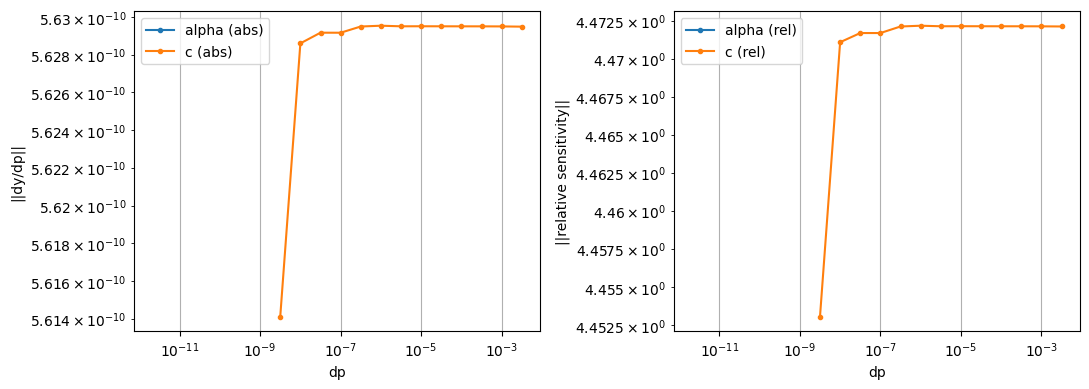

In [8]:
# Relative sensitivity: unitless measure (% change in y per % change in p)
def relative_sensitivity(p, pname, dp, u0=1.0):
    y0 = compute_y(p, u0)
    dY = finite_diff_sens(p, pname, dp, u0)
    pval = float(p[pname])
    eps = 1e-16
    rel = (dY.flatten() / (np.abs(y0.flatten()) + eps)) * (abs(pval) if pval != 0 else 1.0)
    return np.linalg.norm(rel)

Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
eps = np.finfo(float).eps
base_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
base_c     = math.sqrt(2*eps) * max(1.0, abs(p['c']))
mult = 10.0 ** np.linspace(-4, 2, 13)
dp_alpha_sweep = base_alpha * mult
dp_c_sweep     = base_c * mult

abs_alpha = [np.linalg.norm(finite_diff_sens(p, 'alpha', dp)) for dp in dp_alpha_sweep]
abs_c     = [np.linalg.norm(finite_diff_sens(p, 'c', dp))     for dp in dp_c_sweep]
rel_alpha = [relative_sensitivity(p, 'alpha', dp) for dp in dp_alpha_sweep]
rel_c     = [relative_sensitivity(p, 'c', dp)     for dp in dp_c_sweep]

fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].loglog(dp_alpha_sweep, abs_alpha, '.-', label='alpha (abs)')
ax[0].loglog(dp_c_sweep,     abs_c,     '.-', label='c (abs)')
ax[0].set_xlabel('dp')
ax[0].set_ylabel('||dy/dp||')
ax[0].legend()

ax[1].loglog(dp_alpha_sweep, rel_alpha, '.-', label='alpha (rel)')
ax[1].loglog(dp_c_sweep,     rel_c,     '.-', label='c (rel)')
ax[1].set_xlabel('dp')
ax[1].set_ylabel('||relative sensitivity||')
ax[1].legend()
plt.tight_layout(); plt.show()


## Transient QoI — α effect (peak hydrophone amplitude)

Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog

  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4

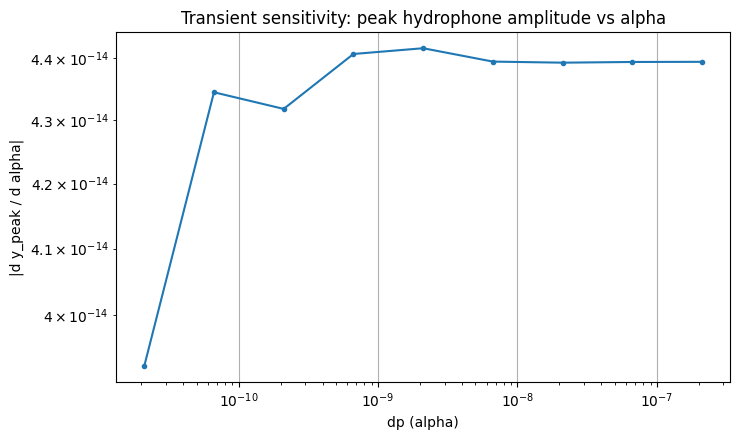

In [9]:
# Use a short leapfrog run; define QoI as max |y(t)| across hydrophones
def peak_hydrophone_amplitude(p, num_iter, dt):
    # Use baseline x_start from fresh params to align shapes
    q, x_start, _, _, _ = getParam_Sonar(p['Nx'], p['Nz'], p['Lx'], p['Lz'], UseSparseMatrices=sp.issparse(p['A']))
    # copy A/B from p (may be modified by rebuild_params_like)
    q['A'] = p['A']; q['B'] = p['B']; q['alpha'] = p['alpha']; q['c'] = p['c']
    X, t = LeapfrogSolver(eval_f_Sonar, x_start, q, eval_u_Sonar, num_iter, dt, visualize=False)
    peak = 0.0
    for i in range(len(t)):
        y = eval_g_Sonar(X[:, i], q)
        peak = max(peak, float(np.max(np.abs(y))))
    return peak

Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, x0, t0, t1, dt_max = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
dt = dt_max * 0.5
num_iter = int(max(10, (t1 - t0) / dt))

eps = np.finfo(float).eps
base_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_sweep = base_alpha * (10.0 ** np.linspace(-3, 1, 9))

y0_peak = peak_hydrophone_amplitude(p, num_iter, dt)
sens = []
for dp in dp_sweep:
    p_pert = rebuild_params_like(p, alpha=p['alpha'] + dp)
    y1_peak = peak_hydrophone_amplitude(p_pert, num_iter, dt)
    sens.append(abs((y1_peak - y0_peak) / dp))

plt.loglog(dp_sweep, sens, '.-')
plt.xlabel('dp (alpha)')
plt.ylabel('|d y_peak / d alpha|')
plt.title('Transient sensitivity: peak hydrophone amplitude vs alpha')
plt.tight_layout(); plt.show()


## Conclusions
- Summarize conditioning trends vs alpha/grid.
- Report stable dp ranges and most influential parameters.
- Note pitfalls (e.g., low damping, boundary extremes).

## Task D — Source location sensitivity (steady QoI)

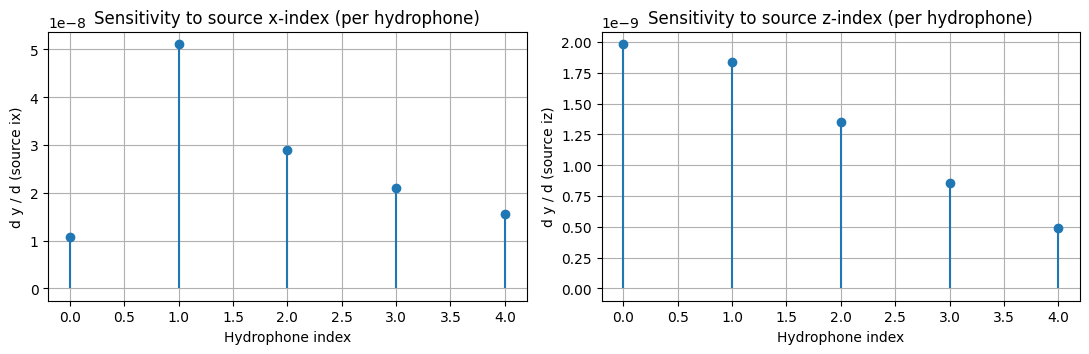

In [10]:
# Central/one-sided FD sensitivity to source indices (per hydrophone)
def sens_source_index(p, axis='x', h=1, u0=1.0):
    y0 = compute_y(p, u0).flatten()
    si, sj = p['sonar_ix'], p['sonar_iz']
    Nx, Nz = p['Nx'], p['Nz']

    if axis == 'x':
        if 0 < si < Nx-1:
            p_plus  = rebuild_params_like(p, sonar_ix=si+h)
            p_minus = rebuild_params_like(p, sonar_ix=si-h)
            y_plus  = compute_y(p_plus, u0).flatten()
            y_minus = compute_y(p_minus, u0).flatten()
            return (y_plus - y_minus) / (2*h)
        elif si == 0:
            p_plus = rebuild_params_like(p, sonar_ix=si+h)
            return (compute_y(p_plus, u0).flatten() - y0) / h
        else:
            p_minus = rebuild_params_like(p, sonar_ix=si-h)
            return (y0 - compute_y(p_minus, u0).flatten()) / h
    else: # axis=='z'
        if 0 < sj < Nz-1:
            p_plus  = rebuild_params_like(p, sonar_iz=sj+h)
            p_minus = rebuild_params_like(p, sonar_iz=sj-h)
            y_plus  = compute_y(p_plus, u0).flatten()
            y_minus = compute_y(p_minus, u0).flatten()
            return (y_plus - y_minus) / (2*h)
        elif sj == 0:
            p_plus = rebuild_params_like(p, sonar_iz=sj+h)
            return (compute_y(p_plus, u0).flatten() - y0) / h
        else:
            p_minus = rebuild_params_like(p, sonar_iz=sj-h)
            return (y0 - compute_y(p_minus, u0).flatten()) / h

# Example per-hydrophone sensitivities for source x/z indices
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
S_ix = sens_source_index(p, axis='x')
S_iz = sens_source_index(p, axis='z')

fig, ax = plt.subplots(1,2, figsize=(11,3.8))
ax[0].stem(np.arange(len(S_ix)), S_ix, basefmt=' ')
ax[0].set_xlabel('Hydrophone index')
ax[0].set_ylabel('d y / d (source ix)')
ax[0].set_title('Sensitivity to source x-index (per hydrophone)')
ax[1].stem(np.arange(len(S_iz)), S_iz, basefmt=' ')
ax[1].set_xlabel('Hydrophone index')
ax[1].set_ylabel('d y / d (source iz)')
ax[1].set_title('Sensitivity to source z-index (per hydrophone)')
plt.tight_layout(); plt.show()


## Task D — Sensitivity heatmap across hydrophones

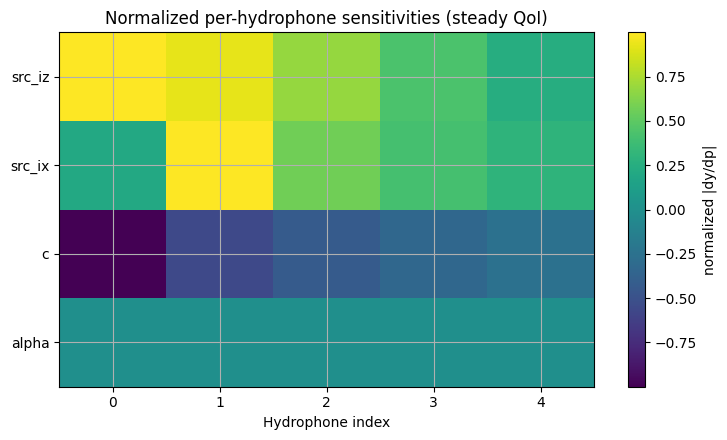

In [11]:
# Build a per-parameter, per-hydrophone sensitivity heatmap (normalized per row)
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
eps = np.finfo(float).eps
dp_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_c     = math.sqrt(2*eps) * max(1.0, abs(p['c']))

s_alpha = finite_diff_sens(p, 'alpha', dp_alpha).flatten()
s_c     = finite_diff_sens(p, 'c', dp_c).flatten()
s_ix    = sens_source_index(p, axis='x').flatten()
s_iz    = sens_source_index(p, axis='z').flatten()

S = np.vstack([s_alpha, s_c, s_ix, s_iz])
# Row-normalize for pattern comparison
S_norm = S / (np.max(np.abs(S), axis=1, keepdims=True) + 1e-16)
labels = ['alpha','c','src_ix','src_iz']

plt.imshow(S_norm, aspect='auto', origin='lower', cmap='viridis')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Hydrophone index')
plt.title('Normalized per-hydrophone sensitivities (steady QoI)')
plt.colorbar(label='normalized |dy/dp|')
plt.tight_layout(); plt.show()


## Task D — Relative source-location sensitivities (unitless)

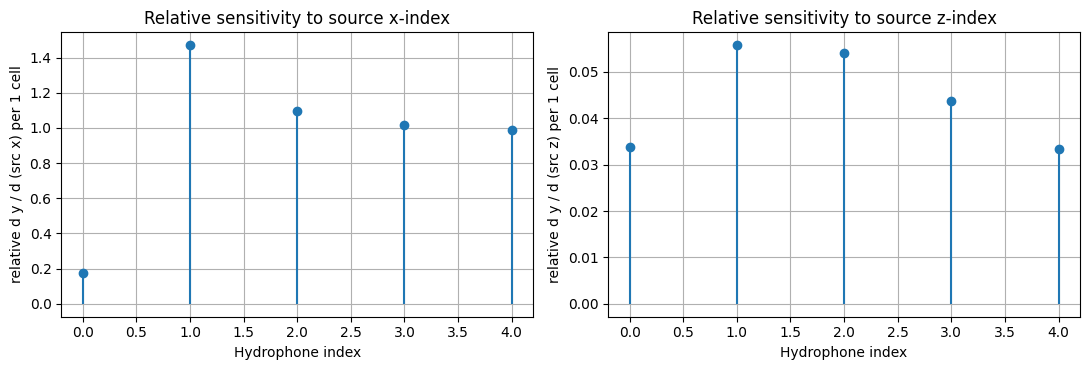

In [12]:
# Compute unitless relative sensitivities for source indices: (1/y) dy/d(index) * (cell size)
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
y0 = compute_y(p).flatten()
S_ix = sens_source_index(p, axis='x').flatten()
S_iz = sens_source_index(p, axis='z').flatten()
epsy = 1e-16
Srel_ix = (S_ix * p['dx']) / (np.abs(y0) + epsy)
Srel_iz = (S_iz * p['dz']) / (np.abs(y0) + epsy)

fig, ax = plt.subplots(1,2, figsize=(11,3.8))
ax[0].stem(np.arange(len(Srel_ix)), Srel_ix, basefmt=' ')
ax[0].set_xlabel('Hydrophone index')
ax[0].set_ylabel('relative d y / d (src x) per 1 cell')
ax[0].set_title('Relative sensitivity to source x-index')
ax[1].stem(np.arange(len(Srel_iz)), Srel_iz, basefmt=' ')
ax[1].set_xlabel('Hydrophone index')
ax[1].set_ylabel('relative d y / d (src z) per 1 cell')
ax[1].set_title('Relative sensitivity to source z-index')
plt.tight_layout(); plt.show()


## Task D — Signed sensitivity heatmap (steady QoI)

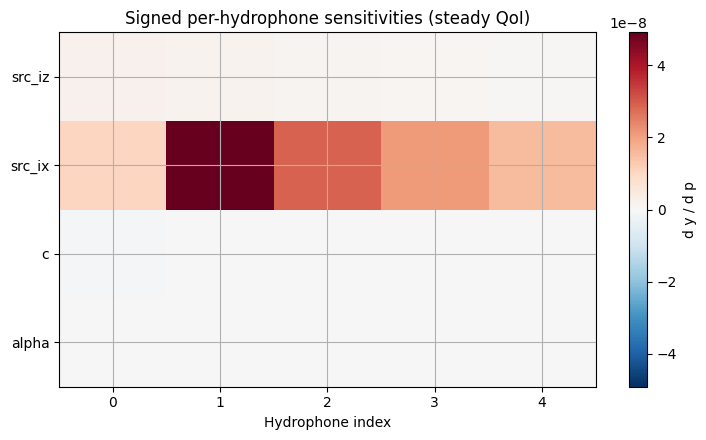

In [13]:
# Signed (not normalized) sensitivities to show direction of influence
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
eps = np.finfo(float).eps
dp_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_c     = math.sqrt(2*eps) * max(1.0, abs(p['c']))

s_alpha = finite_diff_sens(p, 'alpha', dp_alpha).flatten()
s_c     = finite_diff_sens(p, 'c', dp_c).flatten()
s_ix    = sens_source_index(p, axis='x').flatten()
s_iz    = sens_source_index(p, axis='z').flatten()

S_signed = np.vstack([s_alpha, s_c, s_ix, s_iz])
labels = ['alpha','c','src_ix','src_iz']
# Symmetric color scale around zero for visibility
vmax = np.quantile(np.abs(S_signed), 0.995)
vmin = -vmax
plt.imshow(S_signed, aspect='auto', origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Hydrophone index')
plt.title('Signed per-hydrophone sensitivities (steady QoI)')
plt.colorbar(label='d y / d p')
plt.tight_layout(); plt.show()


### Sensitivity heatmap (normalized)
- Rows normalized to compare patterns across parameters.
- c shows broad influence; α ~ 0 for steady QoI; source ix/iz show spatial gradients along the array.